# Deaths and Hospitals

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import load_google_mobility, load_deaths, load_interventions, load_counties, load_google_mobility_time_series
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 05-08
Deaths Last Updated 05-08


In [3]:
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [4]:
cum_deaths = pd.concat((deaths['FIPS'], deaths[death_dates].interpolate('linear', axis=1).sum(axis=1)), axis=1)
cum_deaths.columns = ['FIPS','cum_deaths']

In [5]:
cum_deaths = pd.merge(cum_deaths, counties[['FIPS','Total Hospitals (2019)', 'ICU Beds']], on='FIPS')

In [6]:
cum_deaths.head(3)

,FIPS,cum_deaths,Total Hospitals (2019),ICU Beds
0,1001.0,49,1.148905,6.0
1,1003.0,69,4.505074,51.0
2,1005.0,4,0.514126,5.0


In [7]:
cum_deaths[['cum_deaths','Total Hospitals (2019)', 'ICU Beds']].corr('spearman')

,cum_deaths,Total Hospitals (2019),ICU Beds
cum_deaths,1.000000,0.615371,0.589882
Total Hospitals (2019),0.615371,1.000000,0.774102
ICU Beds,0.589882,0.774102,1.000000


In [8]:
confounders = [
    'POP_ESTIMATE_2018',
    'Density per square mile of land area - Population',
    'Rural-urban_Continuum Code_2013',
    'Total_age65plus',
]
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + confounders], on='FIPS')

In [10]:
def normalize(row):
    deaths = row['cum_deaths']
    pop = row['POP_ESTIMATE_2018']
    density = 1#row['Density per square mile of land area - Population']
    rucc = 1#row['Rural-urban_Continuum Code_2013']
    return(deaths / pop / density / rucc)

In [27]:
cum_deaths['normalized_deaths'] = cum_deaths.apply(lambda row: normalize(row), axis=1)
cum_deaths['percent_age65plus'] = cum_deaths.apply(lambda row: row['Total_age65plus'] / row['POP_ESTIMATE_2018'], axis=1)

In [28]:
cum_deaths.corr('spearman')

,FIPS,cum_deaths,Total Hospitals (2019),ICU Beds,POP_ESTIMATE_2018,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Total_age65plus,normalized_deaths,percent_age65plus
FIPS,1.000000,-0.112555,-0.017839,-0.027466,-0.009595,-0.001926,-0.002854,0.000038,-0.125755,0.060255
cum_deaths,-0.112555,1.000000,0.615371,0.589882,0.667044,0.631099,-0.555014,0.654133,0.952533,-0.367197
Total Hospitals (2019),-0.017839,0.615371,1.000000,0.774102,0.926742,0.757152,-0.689715,0.902647,0.462255,-0.497122
ICU Beds,-0.027466,0.589882,0.774102,1.000000,0.808011,0.705019,-0.555136,0.802214,0.434109,-0.366877
POP_ESTIMATE_2018,-0.009595,0.667044,0.926742,0.808011,1.000000,0.861389,-0.760960,0.985945,0.513150,-0.477320
Density per square mile of land area - Population,-0.001926,0.631099,0.757152,0.705019,0.861389,1.000000,-0.742451,0.849841,0.501885,-0.432330
Rural-urban_Continuum Code_2013,-0.002854,-0.555014,-0.689715,-0.555136,-0.760960,-0.742451,1.000000,-0.730949,-0.443984,0.469618
Total_age65plus,0.000038,0.654133,0.902647,0.802214,0.985945,0.849841,-0.730949,1.000000,0.500963,-0.344116
normalized_deaths,-0.125755,0.952533,0.462255,0.434109,0.513150,0.501885,-0.443984,0.500963,1.000000,-0.289738
percent_age65plus,0.060255,-0.367197,-0.497122,-0.366877,-0.477320,-0.432330,0.469618,-0.344116,-0.289738,1.000000


In [51]:
cum_deaths[['normalized_deaths_log', 'Total Hospitals (2019) log']] = cum_deaths[['normalized_deaths', 'Total Hospitals (2019)']].transform('log')

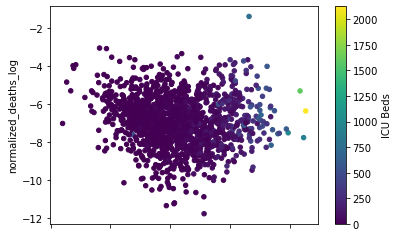

In [56]:
cum_deaths.plot.scatter(x='Total Hospitals (2019) log', y='normalized_deaths_log',c='ICU Beds',colormap='viridis')

In [15]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

In [20]:
calculate_pvalues(cum_deaths[['normalized_deaths', 'ICU Beds', 'Total Hospitals (2019)', 'Total_age65plus']])

,normalized_deaths,ICU Beds,Total Hospitals (2019),Total_age65plus
normalized_deaths,0,0,0,0
ICU Beds,0,0,0,0
Total Hospitals (2019),0,0,0,0
Total_age65plus,0,0,0,0
